In [1]:
%env TF_ENABLE_ONEDNN_OPTS 0

env: TF_ENABLE_ONEDNN_OPTS=0


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# DSA5205 Project

Ref:
- [AlphaNet：因子挖掘神经网络 - 华泰证券](https://crm.htsc.com.cn/doc/2020/10750101/74856806-a2e3-41cb-be4c-695dc6cc1341.pdf)
- [再探AlphaNet：结构和特征优化 - 华泰证券](https://crm.htsc.com.cn/doc/2020/10750101/74619658-f648-4001-a255-5b78174b073a.pdf)

# 1. calculation functions

In [4]:
#combination c^2_N
def generate(N):
    col = []
    col_rev = []
    for i in range(1,N):
        for j in range(0,i):
            col.append([i,j])
    return col

# 2. feature generation

In [5]:
def ts_corr(Matrix,stride):
#Matrix: tensorflow(none, 9, 30)
    W = Matrix.shape[2]
    H = Matrix.shape[1]
    num=generate(H)
    if W % stride == 0:
        Index_list = list(np.arange(0,W+stride,stride))
    else:
        mod = W % stride
        Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
    l = []
    for i in range(len(Index_list)-1):
        start_index = Index_list[i]
        end_index = Index_list[i+1]
        #N*len(num)*2*stride
        data1 = tf.gather(Matrix,axis=1,indices=num)[:,:,:,start_index:end_index]
        mean1 = tf.reduce_mean(data1, axis=-1)
        spread1 = data1 - tf.expand_dims(mean1, axis=-1)
        #N*len(num)*2*1
        std=(tf.reduce_sum(spread1*spread1,axis=-1, keepdims=True)/(spread1.shape[-1]-1))**0.5
        #N*len(num)*1
        cov=tf.reduce_sum(tf.reduce_prod(spread1, axis=-2), axis=-1, keepdims=True)/(data1.shape[-1]-1)
        corr=cov/tf.reduce_prod(std,axis=-2)

        l.append(corr)

    return tf.concat(l,axis=-1) #N*len(num)*[W/H]

In [6]:
def ts_cov(Matrix,stride):
#Matrix: tensorflow(none, 9, 30)
    W = Matrix.shape[2]
    H = Matrix.shape[1]
    num=generate(H)
    if W % stride == 0:
        Index_list = list(np.arange(0,W+stride,stride))
    else:
        mod = W % stride
        Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
    l = []
    for i in range(len(Index_list)-1):
        start_index = Index_list[i]
        end_index = Index_list[i+1]
        #N*len(num)*2*stride
        data1 = tf.gather(Matrix,axis=1,indices=num)[:,:,:,start_index:end_index]
        mean1 = tf.reduce_mean(data1, axis=-1)
        spread1 = data1 - tf.expand_dims(mean1, axis=-1)
        #N*len(num)*1
        cov=tf.reduce_sum(tf.reduce_prod(spread1, axis=-2), axis=-1, keepdims=True)/(data1.shape[-1]-1)

        l.append(cov)

    return tf.concat(l,axis=-1) #N*len(num)*[W/H]

In [7]:
def ts_stdde(Matrix,stride):
#Matrix: tensorflow(none, 9, 30)
    W = Matrix.shape[2]

    if W % stride == 0:
        Index_list = list(np.arange(0,W+stride,stride))
    else:
        mod = W % stride
        Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
    l = []
    for i in range(len(Index_list)-1):
        start_index = Index_list[i]
        end_index = Index_list[i+1]
        #N*H*stride
        data1 = Matrix[:,:,start_index:end_index]
        mean1 = tf.reduce_mean(data1, axis=-1)
        spread1 = data1 - tf.expand_dims(mean1, axis=-1)
        #N*H*1
        std=(tf.reduce_sum(spread1*spread1,axis=-1, keepdims=True)/(spread1.shape[-1]-1))**0.5

        l.append(std)

    return tf.concat(l,axis=-1) #N*H*[W/H]

In [8]:
def ts_zscore(Matrix,stride):
#Matrix: tensorflow(none, 9, 30)
    W = Matrix.shape[2]
    if W % stride == 0:
        Index_list = list(np.arange(0,W+stride,stride))
    else:
        mod = W % stride
        Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
    l = []
    for i in range(len(Index_list)-1):
        start_index = Index_list[i]
        end_index = Index_list[i+1]
        #N*H*stride
        data1 = Matrix[:,:,start_index:end_index]
        mean1 = tf.reduce_mean(data1, axis=-1)
        spread1 = data1 - tf.expand_dims(mean1, axis=-1)
        #N*H*1
        std=(tf.reduce_sum(spread1*spread1,axis=-1, keepdims=True)/(spread1.shape[-1]-1))**0.5

        l.append(tf.expand_dims(mean1, axis=-1)/std)

    return tf.concat(l,axis=-1) #N*H*[W/H]

In [9]:
def ts_return(Matrix,stride):
#Matrix: tensorflow(none, 9, 30)
    W = Matrix.shape[2]
    if W % stride == 0:
        Index_list = list(np.arange(0,W+stride,stride))
    else:
        mod = W % stride
        Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
    l = []
    for i in range(len(Index_list)-1):
        start_index = Index_list[i]
        end_index = Index_list[i+1]
        #N*H*1
        data1 = Matrix[:,:,start_index:end_index]
        return_ = (data1[:,:,-1]-data1[:,:,0])/(data1[:,:,0]+0.0001)-1
        l.append(tf.expand_dims(return_, axis=-1))

    return tf.concat(l,axis=-1) #N*H*[W/H]

In [10]:
def ts_decaylinear(Matrix,stride):
#Matrix: tensorflow(none, 9, 30)
    W = Matrix.shape[2]
    if W % stride == 0:
        Index_list = list(np.arange(0,W+stride,stride))
    else:
        mod = W % stride
        Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
    l = []
    for i in range(len(Index_list)-1):
        start_index = Index_list[i]
        end_index = Index_list[i+1]
        #N*H*stride
        data1 = Matrix[:,:,start_index:end_index]
        range_ = end_index-start_index
        weight = tf.range(1,range_+1,dtype=Matrix.dtype)
        weight = weight/tf.reduce_sum(weight)
        #N*H*1
        wd = tf.reduce_sum(data1*weight, axis=-1, keepdims=True)
        l.append(wd)

    return tf.concat(l,axis=-1) #N*H*[W/H]

In [11]:
def ts_min(Matrix,stride):
#Matrix: tensorflow(none, 9, 30)
    W = Matrix.shape[2]
    if W % stride == 0:
        Index_list = list(np.arange(0,W+stride,stride))
    else:
        mod = W % stride
        Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
    l = []
    for i in range(len(Index_list)-1):
        start_index = Index_list[i]
        end_index = Index_list[i+1]
        #N*H*stride
        data1 = Matrix[:,:,start_index:end_index]
        #N*H*1
        l.append(tf.reduce_min(data1,axis=-1, keepdims=True))

    return tf.concat(l,axis=-1) #N*H*[W/H]

In [12]:
def ts_max(Matrix,stride):
#Matrix: tensorflow(none, 9, 30)
    W = Matrix.shape[2]
    if W % stride == 0:
        Index_list = list(np.arange(0,W+stride,stride))
    else:
        mod = W % stride
        Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
    l = []
    for i in range(len(Index_list)-1):
        start_index = Index_list[i]
        end_index = Index_list[i+1]
        #N*H*stride
        data1 = Matrix[:,:,start_index:end_index]
        #N*H*1
        l.append(tf.reduce_max(data1,axis=-1, keepdims=True))

    return tf.concat(l,axis=-1) #N*H*[W/H]

In [13]:
def ts_mean(Matrix,stride):
#Matrix: tensorflow(none, 9, 30)
    W = Matrix.shape[2]
    if W % stride == 0:
        Index_list = list(np.arange(0,W+stride,stride))
    else:
        mod = W % stride
        Index_list = list(np.arange(0,W+stride-mod,stride)) + [W]
    l = []
    for i in range(len(Index_list)-1):
        start_index = Index_list[i]
        end_index = Index_list[i+1]
        #N*H*stride
        data1 = Matrix[:,:,start_index:end_index]
        #N*H*1
        l.append(tf.reduce_mean(data1,axis=-1, keepdims=True))

    return tf.concat(l,axis=-1) #N*H*[W/H]

## 2.1 check the output of each feature

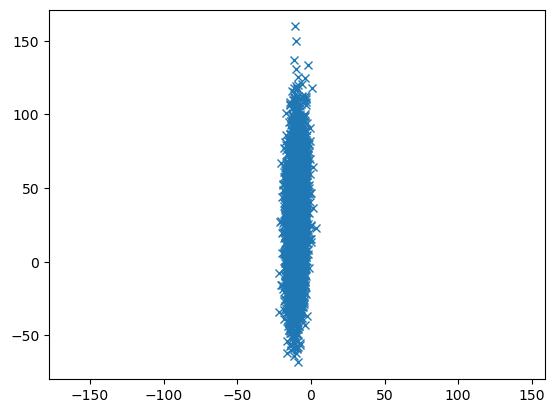

In [14]:
import matplotlib.pyplot as plt
mean = [-10, 30]
cov = [[10, 20], [20, 1000]]
x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [15]:
#just for test, so the dimension may be different with real dataset
testdata=tf.transpose(tf.constant(np.random.multivariate_normal(mean, cov, [2,30000])), perm=[0, 2, 1])
testdata

<tf.Tensor: shape=(2, 2, 30000), dtype=float64, numpy=
array([[[-15.75742135,  -4.17356137, -10.7663813 , ...,  -4.04914174,
          -6.67246448,  -9.87295947],
        [ 47.46242166,  52.59446766,  24.98364518, ...,  66.45530049,
           3.56295759,   4.11905603]],

       [[-10.76635892,  -7.52960061, -10.23906048, ..., -10.99098811,
         -16.19719575,  -6.97066852],
        [ 27.57098291,  58.74370421,  21.42311725, ...,   7.65747192,
          44.97805404,  22.83737907]]])>

In [16]:
#20/(10*1000)**0.5=0.2
ts_corr(testdata,10000)

<tf.Tensor: shape=(2, 1, 3), dtype=float64, numpy=
array([[[0.2115261 , 0.22022766, 0.20351491]],

       [[0.19966508, 0.19659311, 0.21261218]]])>

In [17]:
#20
ts_cov(testdata,10000)

<tf.Tensor: shape=(2, 1, 3), dtype=float64, numpy=
array([[[21.13518317, 22.34940007, 20.28222315]],

       [[20.1287455 , 19.79609071, 21.22418054]]])>

In [18]:
#x_std=10**0.5 about 3.162;y_std=1000**0.5
ts_stdde(testdata,10000)

<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
array([[[ 3.14220683,  3.18325109,  3.13991592],
        [31.79854743, 31.88035263, 31.73959004]],

       [[ 3.20222085,  3.16102321,  3.13394592],
        [31.48207165, 31.85542877, 31.85306972]]])>

In [19]:
#x_mean/x_std=-10**0.5 ; y_mean/y_std=0.3*10**0.5
ts_zscore(testdata,10000)

<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
array([[[-3.16279708, -3.14830375, -3.1908615 ],
        [ 0.95155547,  0.9382892 ,  0.94061304]],

       [[-3.13059062, -3.14243386, -3.19795799],
        [ 0.94528798,  0.95202051,  0.95077023]]])>

In [20]:
ts_return(testdata,10000)

<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
array([[[-1.34416765, -1.17652169, -1.10287402],
        [ 0.1308571 ,  0.95868341, 25.77404509]],

       [[-1.38017574, -0.51808264, -1.47018865],
        [ 1.21130223, -1.53660849, -3.30270938]]])>

In [21]:
ts_decaylinear(testdata,10000)

<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
array([[[ -9.9493005 ,  -9.99250393, -10.0090058 ],
        [ 30.10528315,  29.88294016,  29.96024052]],

       [[-10.02038233,  -9.90232576, -10.03849449],
        [ 30.0510547 ,  30.37508561,  30.35226855]]])>

In [22]:
ts_min(testdata,10000)

<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
array([[[ -20.77615783,  -25.33757427,  -21.82059827],
        [ -99.68801961,  -95.74265617,  -97.83824352]],

       [[ -21.88905825,  -22.24954393,  -22.42040972],
        [-135.93250267, -115.78542852,  -96.19075795]]])>

In [23]:
ts_max(testdata,10000)

<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
array([[[  2.15233175,   1.98559515,   2.50981615],
        [148.42156481, 146.40681921, 156.03723365]],

       [[  5.11975546,   2.65898499,   1.83252837],
        [163.69574628, 144.18484646, 161.14819873]]])>

In [24]:
ts_mean(testdata,10000)

<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
array([[[ -9.93816258, -10.02184136, -10.01903681],
        [ 30.25808162,  29.91299043,  29.85467217]],

       [[-10.02484255,  -9.93330638, -10.02222741],
        [ 29.75962378,  30.32702153,  30.2849504 ]]])>

From the results above, the dimensions of outputs and statistics properties are right.

# 3. block construction

In [25]:
class alphanet_feature_Block(tf.keras.Model):
    def __init__(self, stride):
        super(alphanet_feature_Block, self).__init__(name='')
        #stride: tensorflow/array(2,)
        self.stride_feature, self.stride_pool = stride

        #pooling layers
        self.max_pool = tf.keras.layers.MaxPooling2D(pool_size=(1, 3),strides=(1, self.stride_pool), padding='valid')
        self.mean_pool = tf.keras.layers.AveragePooling2D(pool_size=(1, 3),strides=(1, self.stride_pool), padding='valid')
        #different in input and output
        self.min_pool = tf.keras.layers.MaxPooling2D(pool_size=(1, 3),strides=(1, self.stride_pool), padding='valid')

        #batchnormal for feature input
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.bn5 = tf.keras.layers.BatchNormalization()
        self.bn6 = tf.keras.layers.BatchNormalization()
        self.bn7 = tf.keras.layers.BatchNormalization()

        #batchnormal for pooling layer
        self.bn1mean = tf.keras.layers.BatchNormalization()
        self.bn2mean = tf.keras.layers.BatchNormalization()
        self.bn3mean = tf.keras.layers.BatchNormalization()
        self.bn4mean = tf.keras.layers.BatchNormalization()
        self.bn5mean = tf.keras.layers.BatchNormalization()
        self.bn6mean = tf.keras.layers.BatchNormalization()
        self.bn7mean = tf.keras.layers.BatchNormalization()
        self.bn1max = tf.keras.layers.BatchNormalization()
        self.bn2max = tf.keras.layers.BatchNormalization()
        self.bn3max = tf.keras.layers.BatchNormalization()
        self.bn4max = tf.keras.layers.BatchNormalization()
        self.bn5max = tf.keras.layers.BatchNormalization()
        self.bn6max = tf.keras.layers.BatchNormalization()
        self.bn7max = tf.keras.layers.BatchNormalization()
        self.bn1min = tf.keras.layers.BatchNormalization()
        self.bn2min = tf.keras.layers.BatchNormalization()
        self.bn3min = tf.keras.layers.BatchNormalization()
        self.bn4min = tf.keras.layers.BatchNormalization()
        self.bn5min = tf.keras.layers.BatchNormalization()
        self.bn6min = tf.keras.layers.BatchNormalization()
        self.bn7min = tf.keras.layers.BatchNormalization()



    #output: N*H*[W/H]*1, the last is the number of channel
    def ts_corr(self, input_tensor, stride):
        return tf.expand_dims(ts_corr(input_tensor, stride),axis=-1)


    def ts_cov(self, input_tensor, stride):
        return tf.expand_dims(ts_cov(input_tensor, stride),axis=-1)


    def ts_stdde(self, input_tensor, stride):
        return tf.expand_dims(ts_stdde(input_tensor, stride),axis=-1)


    def ts_zscore(self, input_tensor, stride):
        return tf.expand_dims(ts_zscore(input_tensor, stride),axis=-1)


    def ts_return(self, input_tensor, stride):
        return tf.expand_dims(ts_return(input_tensor, stride),axis=-1)


    def ts_decaylinear(self, input_tensor, stride):
        return tf.expand_dims(ts_decaylinear(input_tensor, stride),axis=-1)


    #below functions could be replaced with pooling layers
    def ts_min(self, input_tensor, stride):
        return tf.expand_dims(ts_min(input_tensor, stride),axis=-1)


    def ts_max(self, input_tensor, stride):
        return tf.expand_dims(ts_max(input_tensor, stride),axis=-1)


    def ts_mean(self, input_tensor, stride):
        return tf.expand_dims(ts_mean(input_tensor, stride),axis=-1)



    def call(self, input_tensor, training=False):
        #input_tensor tensorflow:(N,9,30)
        #feature layer
        x1 = self.ts_corr(input_tensor,self.stride_feature)
        x1 = self.bn1(x1, training=training)
        x1f = tf.keras.layers.Flatten()(x1)

        x2 = self.ts_cov(input_tensor,self.stride_feature)
        x2 = self.bn2(x2, training=training)
        x2f = tf.keras.layers.Flatten()(x2)

        x3 = self.ts_stdde(input_tensor,self.stride_feature)
        x3 = self.bn3(x3, training=training)
        x3f = tf.keras.layers.Flatten()(x3)

        x4 = self.ts_zscore(input_tensor,self.stride_feature)
        x4 = self.bn4(x4, training=training)
        x4f = tf.keras.layers.Flatten()(x4)

        x5 = self.ts_return(input_tensor,self.stride_feature)
        x5 = self.bn5(x5, training=training)
        x5f = tf.keras.layers.Flatten()(x5)

        x6 = self.ts_decaylinear(input_tensor,self.stride_feature)
        x6 = self.bn6(x6, training=training)
        x6f = tf.keras.layers.Flatten()(x6)

        x7 = self.ts_mean(input_tensor,self.stride_feature)
        x7 = self.bn7(x7, training=training)
        x7f = tf.keras.layers.Flatten()(x7)

        #feature output
        feature_output = tf.concat([x1f, x2f, x3f, x4f, x5f, x6f, x7f],axis=-1)

        #pooling layer
        x1mean = self.mean_pool(x1)
        x1mean = self.bn1mean(x1mean, training=training)
        x1max = self.max_pool(x1)
        x1max = self.bn1max(x1max, training=training)
        x1min = -self.min_pool(-x1)
        x1min = self.bn1min(x1min, training=training)
        x1p = tf.concat([tf.keras.layers.Flatten()(x1mean),tf.keras.layers.Flatten()(x1max),tf.keras.layers.Flatten()(x1min)],axis=-1)

        x2mean = self.mean_pool(x2)
        x2mean = self.bn2mean(x2mean, training=training)
        x2max = self.max_pool(x2)
        x2max = self.bn2max(x2max, training=training)
        x2min = -self.min_pool(-x2)
        x2min = self.bn2min(x2min, training=training)
        x2p = tf.concat([tf.keras.layers.Flatten()(x2mean),tf.keras.layers.Flatten()(x2max),tf.keras.layers.Flatten()(x2min)],axis=-1)

        x3mean = self.mean_pool(x3)
        x3mean = self.bn3mean(x3mean, training=training)
        x3max = self.max_pool(x3)
        x3max = self.bn3max(x3max, training=training)
        x3min = -self.min_pool(-x3)
        x3min = self.bn3min(x3min, training=training)
        x3p = tf.concat([tf.keras.layers.Flatten()(x3mean),tf.keras.layers.Flatten()(x3max),tf.keras.layers.Flatten()(x3min)],axis=-1)

        x4mean = self.mean_pool(x4)
        x4mean = self.bn4mean(x4mean, training=training)
        x4max = self.max_pool(x4)
        x4max = self.bn4max(x4max, training=training)
        x4min = -self.min_pool(-x4)
        x4min = self.bn4min(x4min, training=training)
        x4p = tf.concat([tf.keras.layers.Flatten()(x4mean),tf.keras.layers.Flatten()(x4max),tf.keras.layers.Flatten()(x4min)],axis=-1)

        x5mean = self.mean_pool(x5)
        x5mean = self.bn5mean(x5mean, training=training)
        x5max = self.max_pool(x5)
        x5max = self.bn5max(x5max, training=training)
        x5min = -self.min_pool(-x5)
        x5min = self.bn5min(x5min, training=training)
        x5p = tf.concat([tf.keras.layers.Flatten()(x5mean),tf.keras.layers.Flatten()(x5max),tf.keras.layers.Flatten()(x5min)],axis=-1)

        x6mean = self.mean_pool(x6)
        x6mean = self.bn6mean(x6mean, training=training)
        x6max = self.max_pool(x6)
        x6max = self.bn6max(x6max, training=training)
        x6min = -self.min_pool(-x6)
        x6min = self.bn6min(x6min, training=training)
        x6p = tf.concat([tf.keras.layers.Flatten()(x6mean),tf.keras.layers.Flatten()(x6max),tf.keras.layers.Flatten()(x6min)],axis=-1)

        x7mean = self.mean_pool(x7)
        x7mean = self.bn7mean(x7mean, training=training)
        x7max = self.max_pool(x7)
        x7max = self.bn7max(x7max, training=training)
        x7min = -self.min_pool(-x7)
        x7min = self.bn7min(x7min, training=training)
        x7p = tf.concat([tf.keras.layers.Flatten()(x7mean),tf.keras.layers.Flatten()(x7max),tf.keras.layers.Flatten()(x7min)],axis=-1)

        #pooling output
        pooling_output = tf.concat([x1p,x2p,x3p,x4p,x5p,x6p,x7p],axis=-1)

        #output
        output = tf.concat([feature_output,pooling_output],axis=-1)

        return output


In [26]:
def build_AlphaNet(feature_block, input_shape=(9, 30), output_shape=10, name="AlphaNet", dropout_seed=None, version=1):
    r"""
    Build AlphaNet model.

    Parameters
    ----------
    feature_block: alphanet_feature_Block
        Feature extraction model.
    input_shape: int or tuple. optional, default=(9, 30)
        Input data shape. (NOT include batch size)
    output_shape: int, optional, default=10
        Output data shape, i.e. the length of predicted days.
    name: str, optional, default="AlphaNet"
        Model name.
    dropout_seed: None or int, optional, default=None
        Random seed in "Dropout" layer.
    version: {1, 2, 3}, optional, default=1
        Version of AlphaNet. Details can be found in papers. Not supported for 2/3.


    Returns
    -------
    model: tf.keras.Model
        AlphaNet model.
    """
    # input
    inputs = keras.layers.Input(shape=input_shape)
    # feature layers
    x = feature_block(inputs)
    # the rest
    init = keras.initializers.TruncatedNormal(mean=0., stddev=1.)
    if version == 1:   # AlphaNet-v1
        x = keras.layers.Dropout(rate=0.5, seed=dropout_seed, name="Dropout1")(x)
        #x = keras.layers.Dense(30, activation="relu", kernel_initializer=init, name="Dense")(x)
        #sigmoid
        x = keras.layers.Dense(512, activation="sigmoid", kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.), name="Dense1")(x)
        x = keras.layers.Dense(256, activation="sigmoid", kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.), name="Dense2")(x)
        x = keras.layers.Dense(128, activation="sigmoid", kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.), name="Dense3")(x)
        x = keras.layers.Dense(64, activation="sigmoid", kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.), name="Dense4")(x)
        x = keras.layers.Dense(32, activation="sigmoid", kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.), name="Dense5")(x)
    # elif version == 2:  # AlphaNet-v2
    #     x = keras.layers.LSTM(30, activation="relu", name="LSTM")(x)
    #     x = keras.layers.BatchNormalization(name="BN")(x)
    # elif version == 3:  # AlphaNet-v3
    #     x = keras.layers.GRU(30, activation="relu", name="GRU")(x)
    #     x = keras.layers.BatchNormalization(name="BN")(x)
    outputs = keras.layers.Dense(output_shape, activation="linear", kernel_initializer=init, name="Output")(x)

    # create model
    model = keras.Model(inputs=inputs, outputs=outputs, name=name) 

    # complie setting
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    # if version == 1:
    #     optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
    # else:
    #     optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    loss = keras.losses.MeanSquaredError()
    metrics = [keras.metrics.MeanSquaredError(name="MSE")]
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics
    )

    # return
    return model

# 4. Test

In [27]:
mean = np.arange(1,10)
cov = np.eye(9)*[2,3,6,7,2,9,3,5,3]
testdata2 = tf.transpose(tf.constant(np.random.multivariate_normal(mean, cov, [100,30])), perm=[0, 2, 1])
testdata2.shape

TensorShape([100, 9, 30])

In [28]:
testb_feature = alphanet_feature_Block([10,3])
testb = build_AlphaNet(testb_feature, dropout_seed=123, version=1)

In [29]:
modelb = testb(testdata2)

In [30]:
modelb

<tf.Tensor: shape=(100, 10), dtype=float32, numpy=
array([[-6.5306664e+00,  1.8586098e+00,  3.5126410e+00,  1.4437835e+00,
         2.3074940e-01, -2.9630988e+00,  7.3907018e-01, -1.7958735e+00,
         6.4386350e-01,  3.5170426e+00],
       [-6.2037020e+00,  1.8565565e+00,  3.6473076e+00,  4.8624989e-01,
         9.1128391e-01, -2.8971231e+00,  2.9157782e-01, -1.6943736e+00,
        -3.0003089e-01,  1.4384509e+00],
       [-5.6760440e+00,  7.1939754e-01,  3.1726081e+00,  1.3600651e+00,
        -3.0141807e-01, -3.4571893e+00, -1.6597413e-02, -2.3233354e+00,
         3.8481051e-01,  2.6900864e+00],
       [-6.4419460e+00,  1.9739674e+00,  3.1187932e+00,  7.3100233e-01,
         2.8250217e-03, -3.4872067e+00,  4.0120971e-01, -1.4987869e+00,
         1.0594699e+00,  3.4585960e+00],
       [-5.3022666e+00,  2.6973128e-01,  2.9980726e+00,  2.7366006e+00,
         1.6659704e+00, -3.6803391e+00, -6.6283327e-01, -2.9864724e+00,
         6.6226870e-01,  1.2607015e+00],
       [-5.0989451e+00, 

In [31]:
testb.layers

In [32]:
# 7+7*3+3=31
print(len(testb_feature.layers))
# input + feature + dropout + dense * 2
print(len(testb.layers))

31
9


In [33]:
testb.summary()

Model: "AlphaNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9, 30)]           0         
_________________________________________________________________
alphanet_feature__block (alp (None, 702)               112       
_________________________________________________________________
Dropout1 (Dropout)           (None, 702)               0         
_________________________________________________________________
Dense1 (Dense)               (None, 512)               359936    
_________________________________________________________________
Dense2 (Dense)               (None, 256)               131328    
_________________________________________________________________
Dense3 (Dense)               (None, 128)               32896     
_________________________________________________________________
Dense4 (Dense)               (None, 64)                825

In [34]:
testb.variables

[<tf.Variable 'alphanet_feature__block/batch_normalization/gamma:0' shape=(1,) dtype=float32, numpy=array([1.], dtype=float32)>,
 <tf.Variable 'alphanet_feature__block/batch_normalization/beta:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'alphanet_feature__block/batch_normalization/moving_mean:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'alphanet_feature__block/batch_normalization/moving_variance:0' shape=(1,) dtype=float32, numpy=array([1.], dtype=float32)>,
 <tf.Variable 'alphanet_feature__block/batch_normalization_1/gamma:0' shape=(1,) dtype=float32, numpy=array([1.], dtype=float32)>,
 <tf.Variable 'alphanet_feature__block/batch_normalization_1/beta:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'alphanet_feature__block/batch_normalization_1/moving_mean:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'alphanet_feature__block/batch_normalization_1/moving_var

# 5. Real Data Analysis

In [35]:
import os
import h5py
import numpy as np
import pandas as pd

TRAIN_DIR = "train_60"
VALID_DIR = "valid_60"
SAVE_DIR = "saved_model"
OUTPUT_DIR = "output"

def load_hdf5(file):
    r""" 
    Load HDF5 data file and preprocess.
    """
    with h5py.File(file, 'r') as f:
        X, y = f["X"][...], f["y"][...]
    # preprocess: log(1+x)
    X[5, :] = np.log(X[5, :] + 1)
    X[6, :] = np.log(X[6, :] + 1)
    y = np.log(y + 1)
    return X, y

def load_dataset(train_dir, valid_dir):
    r"""
    Load preprocessed datasets.

    Parameters
    ----------
    train_dir: str
        Fold contains training datasets.
    valid_dir: str
        Fold contains test datasets.
    
    Returns
    -------
    value: generator
        A generator for tuples like (name, train_data, valid_data)
    """
    
    for file in os.listdir(train_dir):
        name = file.split("_")[0]
        train_dt = tf.data.Dataset.from_tensor_slices(
            load_hdf5(f"{train_dir}/{name}_train.hdf5")
        )
        valid_dt = tf.data.Dataset.from_tensor_slices(
            load_hdf5(f"{valid_dir}/{name}_valid.hdf5")
        )
        yield (name, train_dt, valid_dt)


In [36]:
STRIDE = (20, 3)    # stride for feature block
BATCH_SIZE = 128
EPOCHS = 100
CALLBACKS = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

all_loss = list()
for name, train_dt, valid_dt in load_dataset(TRAIN_DIR, VALID_DIR):
    feature = alphanet_feature_Block(STRIDE)
    model = build_AlphaNet(
        feature, 
        input_shape=tuple(train_dt.element_spec[0].shape), 
        output_shape=tuple(train_dt.element_spec[1].shape)[0]
    )
    train_dt = train_dt.batch(BATCH_SIZE)
    valid_dt = valid_dt.batch(BATCH_SIZE)
    history = model.fit(
        train_dt,
        epochs=EPOCHS,
        validation_data=valid_dt,
        callbacks=CALLBACKS,
        shuffle=True,
        use_multiprocessing=True,
        workers=10
    )
    all_loss.append({
        "stock": name,
        "epoch": len(history.history["loss"]),
        "train_loss": history.history["loss"][-1],
        "valid_loss": history.history["val_loss"][-1]
    })
    model.save(f"{SAVE_DIR}/{name}_60_log_s203_sigmoid_4layers")
    print(f"Dataset {name} has been trained and saved.")

Epoch 1/100
473/473 [==============================] - 46s 76ms/step - loss: 0.2928 - MSE: 0.2928 - val_loss: 0.0375 - val_MSE: 0.0375
Epoch 2/100
473/473 [==============================] - 36s 76ms/step - loss: 0.0314 - MSE: 0.0314 - val_loss: 0.0116 - val_MSE: 0.0116
Epoch 3/100
473/473 [==============================] - 34s 72ms/step - loss: 0.0125 - MSE: 0.0125 - val_loss: 0.0040 - val_MSE: 0.0040
Epoch 4/100
473/473 [==============================] - 44s 93ms/step - loss: 0.0059 - MSE: 0.0059 - val_loss: 0.0018 - val_MSE: 0.0018
Epoch 5/100
473/473 [==============================] - 19s 39ms/step - loss: 0.0031 - MSE: 0.0031 - val_loss: 9.5113e-04 - val_MSE: 9.5113e-04
Epoch 6/100
473/473 [==============================] - 20s 43ms/step - loss: 0.0018 - MSE: 0.0018 - val_loss: 5.7174e-04 - val_MSE: 5.7174e-04
Epoch 7/100
473/473 [==============================] - 20s 42ms/step - loss: 0.0012 - MSE: 0.0012 - val_loss: 3.6507e-04 - val_MSE: 3.6507e-04
Epoch 8/100
473/473 [==========

In [37]:
temp = pd.DataFrame(all_loss).sort_values("valid_loss").reset_index(drop=True)
temp.to_csv(f"{OUTPUT_DIR}/all_loss_60_log_s203_sigmoid_4layers.csv")
temp

,stock,epoch,train_loss,valid_loss
0,LMT,57,0.000001,8.572648e-07
1,BAH,61,0.000001,9.356373e-07
2,NOC,71,0.000002,1.005361e-06
3,HII,100,0.000002,1.981150e-06
4,STLD,46,0.000003,2.441190e-06
5,MLI,92,0.000004,2.856066e-06
6,AR,59,0.000006,4.604302e-06
7,NFE,53,0.000007,4.939388e-06
8,FTI,5,NaN,NaN
9,PBR,5,NaN,NaN
